![alt text](http://img.blog.csdn.net/20160918133222494)

This notebook I will try to follow real DCGAN architecture to generate Celebrity face.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import misc
sns.set()
face_path = '/home/husein/space/facedataset/img_align_celeba/'

In [2]:
dataset = pd.read_csv('/home/husein/space/discogan/desc.csv')
dataset.head()
print dataset.shape

(202599, 41)


In [3]:
def scale(x):
    return x / 127.5 - 1

def originate(x):
    return (x + 1.) / 2

In [4]:
def generate_sample(samples):
    idx = [i for i in xrange(16)]
    fig, axes = plt.subplots(4, 4, sharex = True, sharey = True, figsize = (5,5))

    for ii, ax in zip(idx, axes.flatten()):
        ax.imshow(originate(samples[ii,:,:,:]), aspect = 'equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()

In [5]:
def generator(z, name, reuse = False, alpha = 0.2, training = True):
    with tf.variable_scope(name, reuse = reuse):
        
        x1 = tf.layers.dense(z, 4 * 4 * 1024)
        x1 = tf.reshape(x1, (-1, 4, 4, 1024))
        x1 = tf.layers.batch_normalization(x1, training = training)
        x1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = training)
        relu2 = tf.maximum(alpha * bn2, bn2)
                
        x3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = training)
        relu3 = tf.maximum(alpha * bn3, bn3)
                
        x4 = tf.layers.conv2d_transpose(relu3, 128, 5, strides = 2, padding = 'same')
        bn4 = tf.layers.batch_normalization(x4, training = training)
        relu4 = tf.maximum(alpha * bn4, bn4)
                
        x5 = tf.layers.conv2d_transpose(relu4, 3, 5, strides = 2, padding = 'same')
                
        return tf.nn.tanh(x5)
                
def discriminator(z, name, reuse = False, alpha = 0.2):
    with tf.variable_scope(name, reuse = reuse):
        x1 = tf.layers.conv2d(z, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
                
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
                
        x4 = tf.layers.conv2d(relu3, 512, 5, strides = 2, padding = 'same')
        bn4 = tf.layers.batch_normalization(x4, training = True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        flat = tf.reshape(relu4, (-1, 4 * 4 * 512))
        logits = tf.layers.dense(flat, 1)
        
        return logits

In [6]:
class DCGAN:
    
    def __init__(self, learning_rate = 0.0002, alpha = 0.2):
        self.X = tf.placeholder(tf.float32, (None, 100))
        self.Y = tf.placeholder(tf.float32, (None, 64, 64, 3))
        
        g_model = generator(self.X, 'generator', alpha = alpha)
        self.g_out = generator(self.X, 'generator', reuse = True, training = False)
        d_logits_real = discriminator(self.Y, 'discriminator', alpha = alpha)
        d_logits_fake = discriminator(g_model, 'discriminator', reuse = True, alpha = alpha)
        
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_logits_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_logits_real)))
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_logits_real)))
        
        self.d_loss = d_loss_real + d_loss_fake
        
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        self.d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.5, beta2 = 0.999).minimize(self.d_loss, var_list = d_vars)
        self.g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.5, beta2 = 0.999).minimize(self.g_loss, var_list = g_vars)

In [7]:
def train(model, dataset, batch, epoch):
    sample_z = np.random.uniform(-1, 1, size = (72, 100))
    LOSS_D, LOSS_G = [], []
    for i in xrange(epoch):
        g_loss, d_loss = 0, 0
        for k in xrange(0, (dataset.shape[0] // batch) * batch, batch):
            batch_x = np.random.uniform(-1, 1, size = (batch, 100))
            batch_y = np.zeros((batch, 64, 64, 3), dtype = np.float32)
            for n in xrange(batch):
                img_y = misc.imread(face_path + dataset.iloc[k + n, 0])
                img_y = misc.imresize(img_y, (64, 64))
                batch_y[n, :, :, :] = scale(img_y)
            _, lossd = sess.run([model.d_train_opt, model.d_loss], feed_dict = {model.X: batch_x, model.Y: batch_y})
            _, lossg_1 = sess.run([model.g_train_opt, model.g_loss], feed_dict = {model.X: batch_x, model.Y: batch_y})
            _, lossg_2 = sess.run([model.g_train_opt, model.g_loss], feed_dict = {model.X: batch_x, model.Y: batch_y})
            g_loss += ((lossg_1 + lossg_2) / 2); d_loss += lossd
        g_loss /= (dataset.shape[0] // batch); d_loss /= (dataset.shape[0] // batch)
        
        print("Epoch {}/{}...".format(i + 1, EPOCH), "Discriminator Loss: {}".format(d_loss), "Generator Loss: {}".format(g_loss))
        LOSS_G.append(g_loss); LOSS_D.append(d_loss)
        
        outputs = sess.run(model.g_out, feed_dict = {model.X: sample_z})
        generate_sample(outputs)
    
    epoch = [i for i in xrange(len(LOSS_D))]
    plt.plot(epoch,LOSS_D, label = 'Discriminator', alpha = 0.5)
    plt.plot(epoch, LOSS_G, label = 'Generator', alpha = 0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [ ]:
EPOCH = 10
BATCH_SIZE = 128

('Epoch 1/10...', 'Discriminator Loss: 1.61695788701', 'Generator Loss: 0.973659914905')


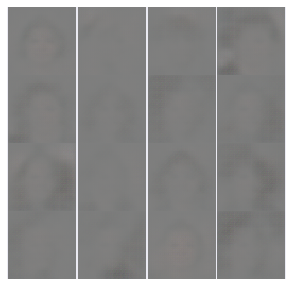

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = DCGAN()
sess.run(tf.global_variables_initializer())
train(model, dataset, BATCH_SIZE, EPOCH)